In [1]:
import os
import re
import copy
import numpy
from IPython.display import Image, display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.data.base import Entry
from rmgpy.data.rmg import RMGDatabase
from rmgpy import settings
from rmgpy.species import Species
from rmgpy.molecule import Molecule
from rmgpy.cantherm.output import prettify

In [2]:
def addThermoData(thermoData1, thermoData2):
    """
    Add the thermodynamic data `thermoData2` to the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] += thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si += thermoData2.H298.value_si
    thermoData1.S298.value_si += thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def removeThermoData(thermoData1, thermoData2):
    """
    Remove the thermodynamic data `thermoData2` from the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] -= thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si -= thermoData2.H298.value_si
    thermoData1.S298.value_si -= thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def averageThermoData(thermoDataset=[]):
    """
    Average a list of thermoData values together.
    Sets uncertainty values to be the approximately the 95% confidence interval, equivalent to
    2 standard deviations calculated using the sample standard variance:
    
    Uncertainty = 2s
    s = sqrt( sum(abs(x - x.mean())^2) / N - 1) where N is the number of values averaged
    
    Note that uncertainties are only computed when number of values is greater than 1.
    """
    
    numValues = len(thermoDataset)
        
    if numValues == 0:
        raise Exception('No thermo data values were inputted to be averaged.')
    else:
        print 'Averaging thermo data over {0} value(s).'.format(numValues)
        
        if numValues == 1:
            return copy.deepcopy(thermoDataset[0])
        
        else:
            averagedThermoData = copy.deepcopy(thermoDataset[0])
            for thermoData in thermoDataset[1:]:
                averagedThermoData = addThermoData(averagedThermoData, thermoData)


            for i in range(averagedThermoData.Tdata.value_si.shape[0]):
                averagedThermoData.Cpdata.value_si[i] /= numValues
                #print averagedThermoData.Cpdata.uncertainty
                cpData = [thermoData.Cpdata.value_si[i] for thermoData in thermoDataset]
                averagedThermoData.Cpdata.uncertainty[i] = 2*numpy.std(cpData, ddof=1)

            HData = [thermoData.H298.value_si for themoData in thermoDataset]
            averagedThermoData.H298.value_si /= numValues
            #print averagedThermoData.H298.getUncertainty()
            #print averagedThermoData.H298.uncertainty
            #print averagedThermoData.H298.uncertainty_si
            averagedThermoData.H298.uncertainty_si = 2*numpy.std(HData, ddof=1)

            SData = [thermoData.S298.value_si for themoData in thermoDataset]
            averagedThermoData.S298.value_si /= numValues
            averagedThermoData.S298.uncertainty_si = 2*numpy.std(SData, ddof=1)
            return averagedThermoData
        
def extractPolycyclicGroups(molecule):
    """
    Extract polycyclic functional groups from a real molecule
    """
    struct = molecule.copy(deep=True)
    
    # Saturate the structure if it is a radical
    if struct.isRadical():
        struct.saturate()
    struct.deleteHydrogens()
    
    polyRings = struct.getPolycyclicRings()
    groups = [convertCycleToGroup(ring) for ring in polyRings]
    
    return groups
                
def convertCycleToGroup(cycle):
    """
    This function converts a list of atoms in a cycle to a functional Group object
    """
    from rmgpy.molecule.group import GroupAtom, GroupBond, Group
    
    # Create GroupAtom object for each atom in the cycle, label the first one in the cycle with a *
    groupAtoms = {}
    bonds = []
    for atom in cycle:
        groupAtoms[atom] = GroupAtom(atomType=[atom.atomType],
                                     radicalElectrons=[0],
                                     label='*' if cycle.index(atom)==0 else '')
                
    group = Group(atoms=groupAtoms.values())            
    
    # Create GroupBond for each bond between atoms in the cycle, but not outside of the cycle
    for atom in cycle:
        for bondedAtom, bond in atom.edges.iteritems():
            if bondedAtom in cycle:
                # create a group bond with the same bond order as in the original molecule,
                # if it hasn't already been created
                if not group.hasBond(groupAtoms[atom],groupAtoms[bondedAtom]):
                    group.addBond(GroupBond(groupAtoms[atom],groupAtoms[bondedAtom],order=[bond.order]))
            else:
                pass
        
    group.update()
    
    return group

In [3]:
m = Molecule(SMILES='C1CC2CCC1C2')
groups = extractPolycyclicGroups(m)
print groups[0].toAdjacencyList()


1 * Cs u0 {6,S} {7,S}
2   Cs u0 {4,S} {7,S}
3   Cs u0 {5,S} {6,S}
4   Cs u0 {2,S} {6,S}
5   Cs u0 {3,S} {7,S}
6   Cs u0 {1,S} {3,S} {4,S}
7   Cs u0 {1,S} {2,S} {5,S}



In [4]:
# Fill in the list of thermo libraries to be used for fitting polycyclic thermo groups
thermoLibraries = ['C10H11']
database = RMGDatabase()
database.load(settings['database.directory'], thermoLibraries = thermoLibraries, kineticsFamilies='none', kineticsDepositories='none', reactionLibraries=[])

thermoDatabase = database.thermo

In [5]:
fittingDictionary={}
for libraryName in thermoLibraries:
    thermoLibrary = database.thermo.libraries[libraryName]

Species pdt7 has a single polycyclic group match in thermo estimate.


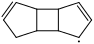

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt7.
Species pdt8 has a single polycyclic group match in thermo estimate.


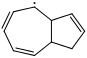

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt8.
Species pdt10bis has a single polycyclic group match in thermo estimate.


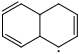

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt10bis.
Species pdt11 has a single polycyclic group match in thermo estimate.


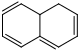

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt11.
Species pdt17 has a single polycyclic group match in thermo estimate.


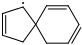

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt17.
Species pdt19 has a single polycyclic group match in thermo estimate.


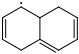

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt19.
Species pdt21 has a single polycyclic group match in thermo estimate.


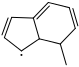

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt21.
Species pdt22 has a single polycyclic group match in thermo estimate.


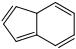

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt22.
Species pdt23 has a single polycyclic group match in thermo estimate.


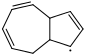

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt23.
Species pdt24 has a single polycyclic group match in thermo estimate.


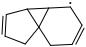

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt24.
Species pdt26 has a single polycyclic group match in thermo estimate.


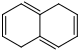

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt26.
Species pdt27 has a single polycyclic group match in thermo estimate.


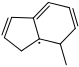

Matched polycyclic group "pdt21"
Species pdt28 has a single polycyclic group match in thermo estimate.


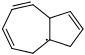

Matched polycyclic group "pdt23"
Species pdt29 has a single polycyclic group match in thermo estimate.


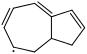

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt29.
Species pdt30 has a single polycyclic group match in thermo estimate.


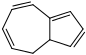

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt30.
Species pdt31 has a single polycyclic group match in thermo estimate.


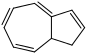

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt31.
Species pdt32 has a single polycyclic group match in thermo estimate.


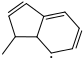

Matched polycyclic group "pdt21"
Species pdt35 has a single polycyclic group match in thermo estimate.


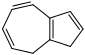

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt35.
Species pdt37 has a single polycyclic group match in thermo estimate.


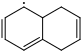

Matched polycyclic group "pdt19"
Species pdt38 has a single polycyclic group match in thermo estimate.


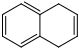

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt38.
Species INDENE has a single polycyclic group match in thermo estimate.


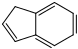

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for INDENE.
Species pdt57 has a single polycyclic group match in thermo estimate.


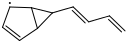

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for pdt57.
Species 2HINDENE has a single polycyclic group match in thermo estimate.


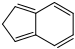

Polycyclic group was found to be generic "PolycyclicRing", creating new entry for 2HINDENE.


In [6]:
for label, entry in thermoLibrary.entries.iteritems():
    molecule = entry.item
    libraryThermoData = entry.data
    if molecule.getAllPolycyclicVertices():
        species = Species(molecule=[molecule])
        #species.generateResonanceIsomers() 
        estimatedThermo = thermoDatabase.getThermoDataFromGroups(species)
        
        tokens = estimatedThermo.comment.split()
        polycyclicGroups = []
        for token in tokens:
            if 'polycyclic' in token:
                splitTokens = re.split("\(|\)",token)
                assert len(splitTokens) == 3
                groupLabel = splitTokens[1]
                polycyclicGroups.append(thermoDatabase.groups['polycyclic'].entries[groupLabel])

        if len(polycyclicGroups) == 0:
            raise Exception('Species {0} detected as polycyclic but estimated thermo contained no polycyclic groups: \
                    you need to create a new polycyclic group'.format(label))
            
        elif len(polycyclicGroups) == 1:
            polycyclicGroup = polycyclicGroups[0]
            print 'Species {0} has a single polycyclic group match in thermo estimate.'.format(label)
            # Draw the molecule in ipython notebook
            display(molecule)
            
            withoutPolycyclicGroupThermo = removeThermoData(copy.deepcopy(estimatedThermo), polycyclicGroup.data)
            newPolycyclicGroupThermo = removeThermoData(copy.deepcopy(libraryThermoData), withoutPolycyclicGroupThermo)
            
            
            # Check to make sure that the polycyclic group is not generic
            # If it is, create a new polycyclicGroup as the child
            if polycyclicGroup.label == 'PolycyclicRing':
                print 'Polycyclic group was found to be generic "PolycyclicRing", creating new entry for {0}.'.format(label)
                groups = extractPolycyclicGroups(molecule)
                assert len(groups) == 1
                # Create a new entry in the polycyclic groups with the same name as the thermo library entry
                thermoDatabase.groups['polycyclic'].entries[label] = Entry(index = len(thermoDatabase.groups['polycyclic'].entries)+1,
                                                                          label = label,
                                                                           item = groups[0],
                                                                           data = polycyclicGroup.data, # Use dummy thermo here so other estimates can find this group
                                                                           parent = polycyclicGroup,
                                                                          )
                
                # Set the new entry as the polycyclicGroup and make it a child of the generic group
                polycyclicGroup = thermoDatabase.groups['polycyclic'].entries[label] 
                thermoDatabase.groups['polycyclic'].entries['PolycyclicRing'].children.append(polycyclicGroup)

            else:
                print 'Matched polycyclic group "{0}"'.format(polycyclicGroup.label)
            
            
            
            
            
            # Add the new group value to the fitting dictionary
            if polycyclicGroup not in fittingDictionary:
                # Add a tuple containing fitted group data, the original library entry, and thermo library
                fittingDictionary[polycyclicGroup]=[(newPolycyclicGroupThermo, entry, thermoLibrary)]
            else:
                fittingDictionary[polycyclicGroup].append((newPolycyclicGroupThermo, entry, thermoLibrary))
                
        elif len(polycyclicGroups) > 1:
            print 'Species {0} has matched multiple polycyclic groups. \
                    This cannot be fitted with a single molecule\'s thermo data.'.format(label)
            raise Exception
        print '====================='

In [7]:
for polycyclicGroup, fittingGroups in fittingDictionary.iteritems():
    print 'Original thermo data for polycyclic group: {0}'.format(polycyclicGroup.label)
    if polycyclicGroup.data:
        print prettify(repr(polycyclicGroup.data))
    else:
        print 'No data found. Was created as a new group.'
    
    thermoDataset = [fitTuple[0] for fitTuple in fittingGroups]
    labels = [fitTuple[1].label for fitTuple in fittingGroups]
    libraryLabels = [fitTuple[2].name for fitTuple in fittingGroups]
    # Average the new group values to fit the original polycyclic group
    fittedGroupData = averageThermoData([fitTuple[0] for fitTuple in fittingGroups])
    #print fittedGroupData
    #print fittingGroups
    polycyclicGroup.data = fittedGroupData
    polycyclicGroup.shortDesc = "Fitted from thermo library values"
    
    comment = ''
    for i in range(len(labels)):
        comment += "Fitted from species {0} from {1} library.\n".format(labels[i],libraryLabels[i])
    polycyclicGroup.longDesc = comment.strip()
    
    print 'Fitted thermo data for polycyclic group: {0}'.format(polycyclicGroup.label)
    print prettify(repr(polycyclicGroup.data))
    print polycyclicGroup.longDesc
    print '===================================================================='
    # At this point, save and overwrite the entire polycyclic thermo library

thermoDatabase.groups['polycyclic'].save('new_polycyclic.py')

Original thermo data for polycyclic group: pdt10bis
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([0, 0, 0, 0, 0, 0, 0], 'cal/(mol*K)'),
    H298 = (0, 'kcal/mol'),
    S298 = (0, 'cal/(mol*K)'),
    comment = 'polycyclic(PolycyclicRing)',
)
Averaging thermo data over 1 value(s).
Fitted thermo data for polycyclic group: pdt10bis
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([-6.41, -6.54, -6.28, -5.42, -4.51, -3.58, -2.22], 'cal/(mol*K)'),
    H298 = (7.943, 'kcal/mol'),
    S298 = (52.87, 'cal/(mol*K)'),
)
Fitted from species pdt10bis from C10H11 library.
Original thermo data for polycyclic group: pdt26
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([0, 0, 0, 0, 0, 0, 0], 'cal/(mol*K)'),
    H298 = (0, 'kcal/mol'),
    S298 = (0, 'cal/(mol*K)'),
    comment = 'polycyclic(PolycyclicRing)',
)
Averaging thermo data over 1 value(s).
Fitted thermo data for polycyclic group: pdt2

In [8]:
def compareThermoData(thermoData1, thermoData2):
    delH = thermoData1.H298.value_si - thermoData2.H298.value_si
    print 'Difference in H298 = {0} kcal/mol'.format(delH/4184)
    delS = thermoData1.S298.value_si - thermoData2.S298.value_si
    print 'Difference S298 = {0} cal/mol*K'.format(delS/4.184)
    Tdata = [300,500,1000,2000]
    for T in Tdata:
        delCp = thermoData1.getHeatCapacity(T) - thermoData2.getHeatCapacity(T)
        print 'Difference in Cp at {0} = {1} cal/mol*K'.format(T, delCp/4.184)

In [11]:
# Test that the new group additivity values can estimate the old library ones exactly.

for label, entry in thermoLibrary.entries.iteritems():
    molecule = entry.item
    libraryThermoData = entry.data
    species = Species(molecule=[molecule])
    #species.generateResonanceIsomers()
    thermoDatabase.findCp0andCpInf(species, libraryThermoData)
    
    if molecule.getAllPolycyclicVertices():
        estimatedThermo = thermoDatabase.getThermoDataFromGroups(species)
        if libraryThermoData.isIdenticalTo(estimatedThermo):
            print 'Library thermo data for species {0} matches the estimate from group additivity.'.format(label)
            #print prettify(repr(estimatedThermo))
        else:
            print 'Library thermo data for species {0} does not match the estimate from group additivity'.format(label)
            print 'Library thermo data:'
            print prettify(repr(libraryThermoData))
            print 'Estimated thermo data:'
            print prettify(repr(estimatedThermo))
            compareThermoData(libraryThermoData,estimatedThermo)
        print '======================='

Library thermo data for species pdt7 matches the estimate from group additivity.
Library thermo data for species pdt8 matches the estimate from group additivity.
Library thermo data for species pdt10bis matches the estimate from group additivity.
Library thermo data for species pdt11 matches the estimate from group additivity.
Library thermo data for species pdt17 matches the estimate from group additivity.
Library thermo data for species pdt19 does not match the estimate from group additivity
Library thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([36.33, 48.88, 59.6, 68.33, 81.28, 90.32, 103.62], 'cal/(mol*K)'),
    H298 = (74.88, 'kcal/mol'),
    S298 = (91.27, 'cal/(mol*K)'),
    Cp0 = (33.2579, 'J/(mol*K)'),
    CpInf = (507.183, 'J/(mol*K)'),
)
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([150.959, 203.677, 248.739, 285.391, 339.762, 377.669, 433.441], 'J/(mol*K)'),
    

In [10]:
# pdt32 debug
m = Molecule(SMILES='CC1C=CC2=CC=CCC21')
s = Species(molecule=[m])
s.generateResonanceIsomers()
print s.molecule
thermoDatabase.groups['polycyclic'].descendTree(m,{},None)

[Molecule(SMILES="CC1C=CC2=CC=CCC21")]


<Entry index=80 label="pdt21">